In [ ]:
import numpy as np
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pan = np.load('/content/drive/MyDrive/kaggle/trainxP.npy')
mulsp = np.load('/content/drive/MyDrive/kaggle/trainxMS.npy')

In [ ]:
mulsp.shape

(1500, 128, 128, 3)

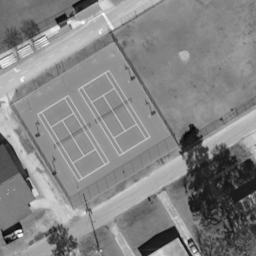

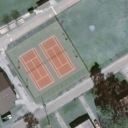

In [ ]:
cv2_imshow(pan[0])
cv2_imshow(mulsp[0]*255)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Model, Sequential

output_channel = 3

def downsample(filters,size,shape,apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = Sequential()
    result.add(Conv3D(filters, size, strides=(1,2,2), padding= 'same', batch_input_shape= shape, kernel_initializer= initializer, use_bias= False))
    if apply_batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

def upsample(filters, size, shape, apply_dropout = False):

    initializer = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv3DTranspose(filters,size,strides=(1,2,2),padding='same',batch_input_shape=shape,kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:

        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

def build_generator():

    inputs = Input(shape=[1,128,128,3])

    down_stack = [
        downsample(64,(1,4,4), (None,1, 128,128,3),apply_batchnorm=False), #64 64 64
        downsample(128, (1,4,4), (None,1,64,64,64)), # 32 32 128
        downsample(256,(1,4,4),(None,1,32,32,128)), #16 16 256
        downsample(512,(1,4,4),(None,1,16,16,256)), # 8 8 512
        downsample(512,(1,4,4),(None,1,8,8,512)), # 4 4 512 
        downsample(512,(1,4,4),(None,1,4,4,512)), # 2 2 512
        downsample(512,(1,4,4),(None,1,2,2,512)) # 1 1 512
    ]

    up_stack = [
        upsample(512,(1,4,4),(None,1,1,1,512),apply_dropout=True), # 2 2 512 
        upsample(512,(1,4,4),(None,1,2,2,1024),apply_dropout=True), # 4 4 512 
        upsample(512,(1,4,4),(None,1,4,4,1024),apply_dropout=True), # 8 8 512
        upsample(256,(1,4,4),(None,1,8,8,1024)), # 16 16 256 
        upsample(128,(1,4,4),(None,1,16,16,512)), # 32 32 128 
        upsample(64,(1,4,4),(None,1,32,32,256)) # 64 64 64
        
    ]

    initializer = tf.random_normal_initializer(0.,0.02)
    last = Conv3DTranspose(output_channel,(1,4,4),strides=(1,2,2),padding='same',kernel_initializer=initializer,activation='sigmoid')
    x = inputs
    skips = []

    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip, in zip(up_stack,skips):
        x= up(x)
        x = Concatenate()([x, skip])
    x = upsample(64,(1,4,4),(None,1,64,64,128))(x)
    x = last(x)
    return Model(inputs = inputs, outputs = x)

generator = build_generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 128, 128, 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1, 64, 64, 64 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1, 32, 32, 12 131584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1, 16, 16, 25 525312      sequential_1[0][0]               
______________________________________________________________________________________________

In [ ]:
def downs(filters,size,apply_batch_norm = True):
    initializer = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv3D(filters, size, strides=2,padding='same',kernel_initializer=initializer, use_bias=False))
    if apply_batch_norm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

def build_discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)
    inp = Input(shape=[1,128,128,3],name='input_img')
    tar = Input(shape=[1,256,256,1],name='target_img')
    tar1 = downs(3,(1,4,4),False)(tar)
    x = Concatenate()([inp, tar1])
    down1 = downs(64,(1,4,4),False)(x)
    down2 = downs(128,(1,4,4))(down1)
    down3 = downs(256,(1,4,4))(down2)
    zero_pad1 = ZeroPadding3D()(down3)
    conv = Conv3D(512,(1,4,4),strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1)
    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    zero_pad2 = ZeroPadding3D()(leaky_relu)
    last = Conv3D(1,(1,4,4),strides=1,kernel_initializer=initializer)(zero_pad2)
    return Model(inputs = [inp,tar], outputs = last)

discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_img (InputLayer)         [(None, 1, 256, 256, 0                                            
__________________________________________________________________________________________________
input_img (InputLayer)          [(None, 1, 128, 128, 0                                            
__________________________________________________________________________________________________
sequential_14 (Sequential)      (None, 1, 128, 128,  48          target_img[0][0]                 
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 1, 128, 128,  0           input_img[0][0]                  
                                                                 sequential_14[0][0]        

In [ ]:
import os
import sys
import datetime
import time 

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 100
epochs = 100

def gen_loss(disc_generated_output,gen_output,target):

    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    loss = tf.abs(target - gen_output)
    l1_loss = tf.reduce_mean(loss)
    total_gen_loss = gan_loss + (LAMBDA*l1_loss)

    return total_gen_loss,gan_loss,l1_loss

def  discriminator_loss(disc_real_output,disc_generated_output):

    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    toal_disc_loss = real_loss + generated_loss
    return toal_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-6,beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-6, beta_1=0.5)

checkpoint_dirs = '/content/drive/MyDrive/GNRproj/sigmoid'
checkpoint_prefix = os.path.join(checkpoint_dirs,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer, discriminator_optimizer = discriminator_optimizer, generator = generator, discriminator = discriminator)

def generated_img(model,test_input,tar):
    prediction = model(test_input,training = False)
    plt.figure(figsize=(15,15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):

        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5 + 0.5)
        plt.axis('off')

    plt.show()

log_dir = "/content/logs"
summary_writer = tf.summary.create_file_writer(log_dir + 'fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
from tqdm import tqdm
@tf.function
def train_step(input_img, target, epoch):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        gen_output = generator(input_img, training = True)
        
        gen_output = gen_output[:,:,:,:,-1]
        disc_real_output = discriminator([input_img,target], training = True)
        disc_generated_output = discriminator([input_img,gen_output], training = True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = gen_loss(disc_generated_output,gen_output,target)
        disc_loss = discriminator_loss(disc_real_output,disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
    discriminator_optimizer.apply_gradients((zip(discriminator_gradients,discriminator.trainable_variables)))

    with summary_writer.as_default():

        tf.summary.scalar('gen_total_loss',gen_total_loss, epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss,step=epoch)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

def fit(epochs):

    batch_size = 4
    for epoch in range(epochs):

        start = time.time()

        print("Epoch {}".format(epoch))
        num=0
        total_input = np.zeros((batch_size,1,128,128,3))
        total_output = np.zeros((batch_size,1,256,256,1))
        for i in tqdm(range(pan.shape[0])):
            # print(m)
          total_input[num][0] = mulsp[i]
          total_output[num][0] = pan[i]/255.0

          num = num + 1

          if num == batch_size:
            num = 0
            total_input = tf.convert_to_tensor(total_input,dtype=tf.float32)
            total_output = tf.convert_to_tensor(total_output,dtype=tf.float32)
            train_step(total_input, total_output, epoch)
            total_input = np.zeros((batch_size,1,128,128,3))
            total_output = np.zeros((batch_size,1,256,256,1))
        print("Time taken for epoch {} is {} sec \n".format(epoch+1, time.time()-start))

        checkpoint.save(file_prefix=checkpoint_prefix)

print("Started Restoring")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dirs))
print("Done Restoring")
fit(epochs)

Started Restoring
Done Restoring
Epoch 0


100%|██████████| 1500/1500 [04:19<00:00,  5.77it/s]


Time taken for epoch 1 is 259.9767179489136 sec 

Epoch 1


100%|██████████| 1500/1500 [04:17<00:00,  5.82it/s]


Time taken for epoch 2 is 257.70855259895325 sec 

Epoch 2


100%|██████████| 1500/1500 [04:10<00:00,  6.00it/s]


Time taken for epoch 3 is 250.11728882789612 sec 

Epoch 3


100%|██████████| 1500/1500 [04:10<00:00,  6.00it/s]


Time taken for epoch 4 is 250.2215769290924 sec 

Epoch 4


100%|██████████| 1500/1500 [04:11<00:00,  5.96it/s]


Time taken for epoch 5 is 251.6391739845276 sec 

Epoch 5


100%|██████████| 1500/1500 [04:12<00:00,  5.95it/s]


Time taken for epoch 6 is 252.08501505851746 sec 

Epoch 6


100%|██████████| 1500/1500 [04:11<00:00,  5.97it/s]


Time taken for epoch 7 is 251.16092991828918 sec 

Epoch 7


100%|██████████| 1500/1500 [04:11<00:00,  5.96it/s]


Time taken for epoch 8 is 251.7319347858429 sec 

Epoch 8


100%|██████████| 1500/1500 [04:11<00:00,  5.98it/s]


Time taken for epoch 9 is 251.0644564628601 sec 

Epoch 9


100%|██████████| 1500/1500 [04:11<00:00,  5.95it/s]


Time taken for epoch 10 is 251.96953582763672 sec 

Epoch 10


100%|██████████| 1500/1500 [04:11<00:00,  5.97it/s]


Time taken for epoch 11 is 251.2368540763855 sec 

Epoch 11


100%|██████████| 1500/1500 [04:12<00:00,  5.94it/s]


Time taken for epoch 12 is 252.52791571617126 sec 

Epoch 12


100%|██████████| 1500/1500 [04:11<00:00,  5.97it/s]


Time taken for epoch 13 is 251.20877861976624 sec 

Epoch 13


100%|██████████| 1500/1500 [04:11<00:00,  5.97it/s]


Time taken for epoch 14 is 251.41931343078613 sec 

Epoch 14


100%|██████████| 1500/1500 [04:10<00:00,  5.98it/s]


Time taken for epoch 15 is 250.80900239944458 sec 

Epoch 15


100%|██████████| 1500/1500 [04:11<00:00,  5.97it/s]


Time taken for epoch 16 is 251.13312220573425 sec 

Epoch 16


100%|██████████| 1500/1500 [04:11<00:00,  5.97it/s]


Time taken for epoch 17 is 251.07385969161987 sec 

Epoch 17


100%|██████████| 1500/1500 [04:12<00:00,  5.94it/s]


Time taken for epoch 18 is 252.4818241596222 sec 

Epoch 18


100%|██████████| 1500/1500 [04:13<00:00,  5.92it/s]


Time taken for epoch 19 is 253.1992154121399 sec 

Epoch 19


100%|██████████| 1500/1500 [04:10<00:00,  5.99it/s]


Time taken for epoch 20 is 250.5918185710907 sec 

Epoch 20


100%|██████████| 1500/1500 [04:10<00:00,  5.98it/s]


Time taken for epoch 21 is 250.9230761528015 sec 

Epoch 21


100%|██████████| 1500/1500 [04:09<00:00,  6.01it/s]


Time taken for epoch 22 is 249.681813955307 sec 

Epoch 22


100%|██████████| 1500/1500 [04:21<00:00,  5.74it/s]


Time taken for epoch 23 is 261.20351791381836 sec 

Epoch 23


100%|██████████| 1500/1500 [04:21<00:00,  5.74it/s]


Time taken for epoch 24 is 261.3545024394989 sec 

Epoch 24


100%|██████████| 1500/1500 [04:22<00:00,  5.72it/s]


Time taken for epoch 25 is 262.20242381095886 sec 

Epoch 25


100%|██████████| 1500/1500 [04:22<00:00,  5.72it/s]


Time taken for epoch 26 is 262.2058494091034 sec 

Epoch 26


100%|██████████| 1500/1500 [04:22<00:00,  5.71it/s]


Time taken for epoch 27 is 262.56052231788635 sec 

Epoch 27


100%|██████████| 1500/1500 [04:22<00:00,  5.71it/s]


Time taken for epoch 28 is 262.71237874031067 sec 

Epoch 28


100%|██████████| 1500/1500 [04:22<00:00,  5.72it/s]


Time taken for epoch 29 is 262.4611668586731 sec 

Epoch 29


100%|██████████| 1500/1500 [04:22<00:00,  5.72it/s]


Time taken for epoch 30 is 262.2738468647003 sec 

Epoch 30


100%|██████████| 1500/1500 [04:22<00:00,  5.71it/s]


Time taken for epoch 31 is 262.715443611145 sec 

Epoch 31


100%|██████████| 1500/1500 [04:23<00:00,  5.70it/s]


Time taken for epoch 32 is 263.1555097103119 sec 

Epoch 32


100%|██████████| 1500/1500 [04:22<00:00,  5.71it/s]


Time taken for epoch 33 is 262.54978489875793 sec 

Epoch 33


100%|██████████| 1500/1500 [04:21<00:00,  5.73it/s]


Time taken for epoch 34 is 261.75856924057007 sec 

Epoch 34


100%|██████████| 1500/1500 [04:23<00:00,  5.69it/s]


Time taken for epoch 35 is 263.8431751728058 sec 

Epoch 35


100%|██████████| 1500/1500 [04:22<00:00,  5.71it/s]


Time taken for epoch 36 is 262.804372549057 sec 

Epoch 36


100%|██████████| 1500/1500 [04:23<00:00,  5.69it/s]


Time taken for epoch 37 is 263.55281805992126 sec 

Epoch 37


100%|██████████| 1500/1500 [04:23<00:00,  5.69it/s]


Time taken for epoch 38 is 263.7172350883484 sec 

Epoch 38


100%|██████████| 1500/1500 [04:23<00:00,  5.68it/s]


Time taken for epoch 39 is 263.96136832237244 sec 

Epoch 39


100%|██████████| 1500/1500 [04:23<00:00,  5.70it/s]


Time taken for epoch 40 is 263.3294343948364 sec 

Epoch 40


100%|██████████| 1500/1500 [04:22<00:00,  5.71it/s]


Time taken for epoch 41 is 262.53390979766846 sec 

Epoch 41


100%|██████████| 1500/1500 [04:24<00:00,  5.67it/s]


Time taken for epoch 42 is 264.4210286140442 sec 

Epoch 42


100%|██████████| 1500/1500 [04:23<00:00,  5.69it/s]


Time taken for epoch 43 is 263.85882449150085 sec 

Epoch 43


100%|██████████| 1500/1500 [04:23<00:00,  5.69it/s]


Time taken for epoch 44 is 263.7337124347687 sec 

Epoch 44


100%|██████████| 1500/1500 [04:24<00:00,  5.68it/s]


Time taken for epoch 45 is 264.1148409843445 sec 

Epoch 45


100%|██████████| 1500/1500 [04:24<00:00,  5.67it/s]


Time taken for epoch 46 is 264.64894127845764 sec 

Epoch 46


100%|██████████| 1500/1500 [04:24<00:00,  5.68it/s]


Time taken for epoch 47 is 264.1205358505249 sec 

Epoch 47


100%|██████████| 1500/1500 [04:24<00:00,  5.66it/s]


Time taken for epoch 48 is 264.8005802631378 sec 

Epoch 48


100%|██████████| 1500/1500 [04:25<00:00,  5.65it/s]


Time taken for epoch 49 is 265.36150217056274 sec 

Epoch 49


 25%|██▌       | 380/1500 [01:16<03:09,  5.92it/s]

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dirs))

In [ ]:
uu = np.load('/content/drive/MyDrive/kaggle/testMS.npy')
ppp = np.load('/content/drive/MyDrive/kaggle/testxP.npy')

(256, 256, 3)


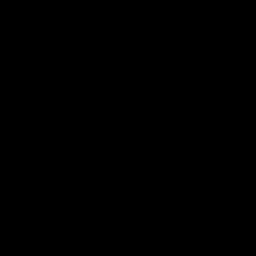

In [ ]:
out = generator(tf.expand_dims(tf.expand_dims(uu[0], axis = 0), axis = 0), training = False)
out = out[0][0].numpy()
print(out.shape) 
cv2_imshow(out*255)

(1, 1, 256, 256, 3)


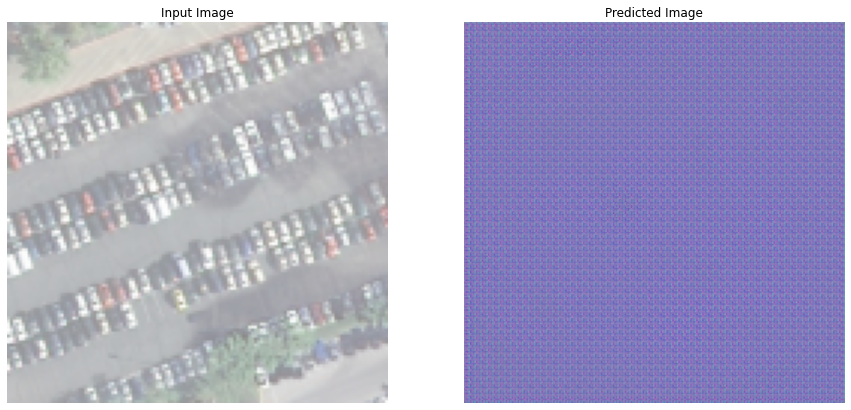

In [ ]:
import matplotlib.pyplot as plt

def generated_img(model,test_input,tar):
    prediction = model(test_input,training = False)
    plt.figure(figsize=(15,15))
    display_list = [test_input[0][0], prediction[0][0]]
    title = ['Input Image', 'Predicted Image']
    print(prediction.shape)
    for i in range(2):

        plt.subplot(1,2,i+1)
        plt.title(title[i])
        plt.imshow(((display_list[i]*0.5 + 0.5)*255).numpy().astype(np.uint8))
        plt.axis('off')

    plt.show()

generated_img(generator,tf.expand_dims(tf.expand_dims(uu[0], axis = 0),axis=0),ppp[0])